In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Problem 1 — Data Exploration

In [3]:
DATA_PATH = r"C:\Users\esmat\Desktop\Assignment\OceanFlow"
u1 = pd.read_csv(f"{DATA_PATH}/1u.csv", header=None)
v1 = pd.read_csv(f"{DATA_PATH}/1v.csv", header=None)

print(u1.shape, v1.shape)



(504, 555) (504, 555)


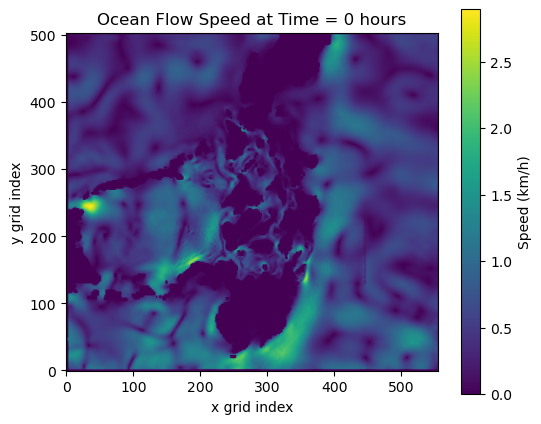

In [4]:
speed = np.sqrt(u1.values**2 + v1.values**2)

plt.figure(figsize=(6,5))
plt.imshow(speed, origin='lower')
plt.colorbar(label="Speed (km/h)")
plt.title("Ocean Flow Speed at Time = 0 hours")
plt.xlabel("x grid index")
plt.ylabel("y grid index")
plt.show()

In [5]:
u_list = []
v_list = []

for t in range(1, 101):
    u = pd.read_csv(f"{DATA_PATH}/{t}u.csv", header=None).values
    v = pd.read_csv(f"{DATA_PATH}/{t}v.csv", header=None).values
    u_list.append(u)
    v_list.append(v)

# convert to 3D arrays: (time, y, x)
U = np.array(u_list)
V = np.array(v_list)

print(U.shape, V.shape)

(100, 504, 555) (100, 504, 555)


In [6]:
Speed = np.sqrt(U**2 + V**2)
var_speed = np.var(Speed, axis=0)

# ignore land points
var_speed[var_speed == 0] = np.nan

min_idx = np.unravel_index(np.nanargmin(var_speed), var_speed.shape)
y_min, x_min = min_idx

# convert to km (grid spacing 3 km)
x_km = x_min * 3
y_km = y_min * 3

print("Smallest variation point (km): x =", x_km, ", y =", y_km)


Smallest variation point (km): x = 510 , y = 363


In [7]:
## PROBLEM 1.b: MAX X-VELOCITY

In [8]:
max_val = np.nanmax(U)
time_idx, y_idx, x_idx = np.unravel_index(np.nanargmax(U), U.shape)

# convert to km and hours
x_km = x_idx * 3
y_km = y_idx * 3
time_hr = time_idx * 3

print("Max x-velocity at time =", time_hr, "hours, x =", x_km, "km, y =", y_km, "km")


Max x-velocity at time = 84 hours, x = 1041 km, y = 543 km


In [9]:
## Problem 1.c — Overall Average Velocity

In [10]:
U_avg = np.mean(U)
V_avg = np.mean(V)

print(f"Average velocity: U = {U_avg:.4f} km/h, V = {V_avg:.4f} km/h")


Average velocity: U = -0.0937 km/h, V = -0.0355 km/h


In [ ]:
#  Problem 2

In [11]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
num_points = 100  

# U.shape = (100, 555, 504)
y_points = np.random.randint(0, U.shape[1], size=num_points)  # 0→554
x_points = np.random.randint(0, U.shape[2], size=num_points)  # 0→503

sample_points = list(zip(y_points, x_points))
print("Sample points (first 5):", sample_points[:5])


Sample points (first 5): [(np.int32(102), np.int32(269)), (np.int32(435), np.int32(270)), (np.int32(348), np.int32(455)), (np.int32(270), np.int32(461)), (np.int32(106), np.int32(251))]


In [12]:
high_corr_threshold = 0.8
correlated_pairs = []

for i in range(num_points):
    y1, x1 = sample_points[i]
    u1 = U[:, y1, x1]
    
    # skip all-zero points (land)
    if np.all(u1 == 0):
        continue
    
    for j in range(i+1, num_points):
        y2, x2 = sample_points[j]
        u2 = U[:, y2, x2]
        
        if np.all(u2 == 0):
            continue
        
        corr = np.corrcoef(u1, u2)[0,1]
        
        if np.isnan(corr):
            continue
        
        if abs(corr) >= high_corr_threshold:
            correlated_pairs.append(((y1, x1), (y2, x2), corr))

print("Number of highly correlated pairs:", len(correlated_pairs))
if correlated_pairs:
    print("First correlated pair:", correlated_pairs[0])


Number of highly correlated pairs: 157
First correlated pair: ((np.int32(348), np.int32(455)), (np.int32(359), np.int32(441)), np.float64(0.9293153198111417))


In [13]:
point1, point2, corr_val = correlated_pairs[0]
y1, x1 = point1
y2, x2 = point2

# grid spacing = 3 km
x1_km, y1_km = x1*3, y1*3
x2_km, y2_km = x2*3, y2*3

print(f"Chosen pair:\nPoint 1: ({x1_km} km, {y1_km} km)\nPoint 2: ({x2_km} km, {y2_km} km)\nCorrelation: {corr_val:.2f}")


Chosen pair:
Point 1: (1365 km, 1044 km)
Point 2: (1323 km, 1077 km)
Correlation: 0.93


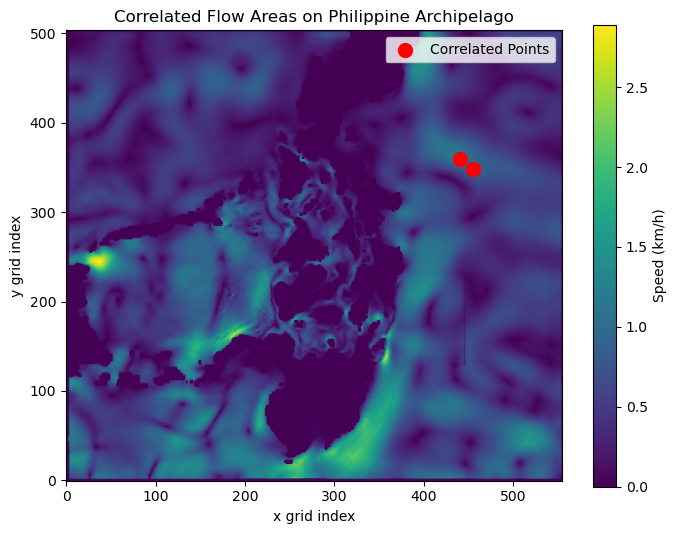

In [14]:
speed_map = np.sqrt(U[0]**2 + V[0]**2)  # first time step

plt.figure(figsize=(8,6))
plt.imshow(speed_map, origin='lower', cmap='viridis')
plt.colorbar(label="Speed (km/h)")
plt.scatter([x1, x2], [y1, y2], color='red', s=100, label='Correlated Points')
plt.title("Correlated Flow Areas on Philippine Archipelago")
plt.xlabel("x grid index")
plt.ylabel("y grid index")
plt.legend()
plt.show()


In [15]:
y_corr = np.corrcoef(V[:, y1, x1], V[:, y2, x2])[0,1]
print(f"Correlation in y-velocity: {y_corr:.2f}")


Correlation in y-velocity: 0.12


In [16]:
# Problem 3 — Particle Simulation

In [17]:
num_particles = 200

# random positions on the map (continuous)
particle_x = np.random.uniform(0, U.shape[2], num_particles)
particle_y = np.random.uniform(0, U.shape[1], num_particles)

In [18]:
epsilon = 1  # 1 hour time step
total_time = 300  # hours
time_steps = total_time

# store trajectories for plotting
traj_x = [particle_x.copy()]
traj_y = [particle_y.copy()]

for t in range(time_steps):
    # find nearest grid point
    ix = np.clip(np.round(particle_x).astype(int), 0, U.shape[2]-1)
    iy = np.clip(np.round(particle_y).astype(int), 0, U.shape[1]-1)
    
    # get velocities from current time (mod 100 because data has 100 snapshots)
    u_vel = U[t % 100, iy, ix]
    v_vel = V[t % 100, iy, ix]
    
    # update positions
    particle_x += u_vel * epsilon
    particle_y += v_vel * epsilon
    
    traj_x.append(particle_x.copy())
    traj_y.append(particle_y.copy())


In [19]:
## Plot initial, intermediate, and final positions

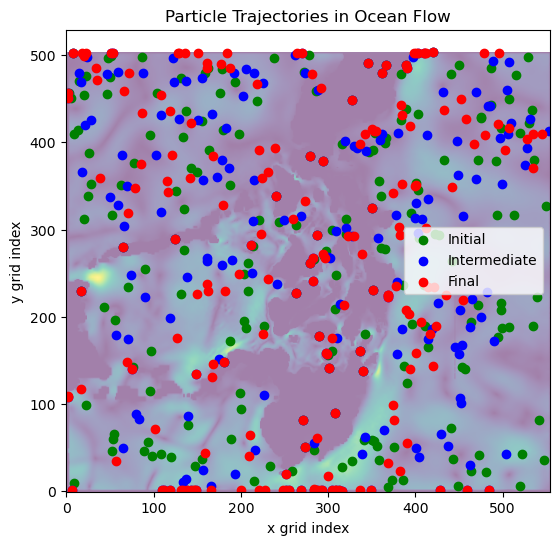

In [20]:
plt.figure(figsize=(8,6))
plt.imshow(speed_map, origin='lower', cmap='viridis', alpha=0.5)
plt.scatter(traj_x[0], traj_y[0], color='green', label='Initial')
plt.scatter(traj_x[100], traj_y[100], color='blue', label='Intermediate')
plt.scatter(traj_x[-1], traj_y[-1], color='red', label='Final')
plt.title("Particle Trajectories in Ocean Flow")
plt.xlabel("x grid index")
plt.ylabel("y grid index")
plt.legend()
plt.show()


In [21]:
## Problem 3.b — Particle Simulation from a Gaussian Crash

In [22]:
num_debris = 200
mean_x, mean_y = 100, 350
sigma = 5  # grid units

# Sample initial debris positions
debris_x = np.random.normal(loc=mean_x, scale=sigma, size=num_debris)
debris_y = np.random.normal(loc=mean_y, scale=sigma, size=num_debris)


In [23]:
epsilon = 1  # 1 hour
simulation_times = [48, 72, 120]

trajectories = {}  # store trajectories at each checkpoint

for t_max in simulation_times:
    x_pos = debris_x.copy()
    y_pos = debris_y.copy()
    
    for t in range(t_max):
        ix = np.clip(np.round(x_pos).astype(int), 0, U.shape[2]-1)
        iy = np.clip(np.round(y_pos).astype(int), 0, U.shape[1]-1)
        
        u_vel = U[t % 100, iy, ix]
        v_vel = V[t % 100, iy, ix]
        
        x_pos += u_vel * epsilon
        y_pos += v_vel * epsilon
    
    trajectories[t_max] = (x_pos.copy(), y_pos.copy())


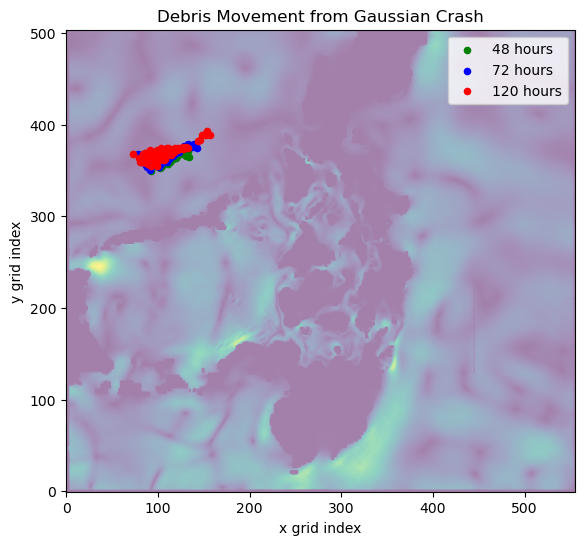

In [24]:
plt.figure(figsize=(8,6))
plt.imshow(speed_map, origin='lower', cmap='viridis', alpha=0.5)

colors = ['green', 'blue', 'red']
labels = ['48 hours', '72 hours', '120 hours']

for i, t in enumerate(simulation_times):
    x_plot, y_plot = trajectories[t]
    plt.scatter(x_plot, y_plot, color=colors[i], label=labels[i], s=20)

plt.title("Debris Movement from Gaussian Crash")
plt.xlabel("x grid index")
plt.ylabel("y grid index")
plt.legend()
plt.show()

In [25]:
# Problem 4 — Gaussian Process Modeling

In [26]:
y_loc, x_loc = 200, 300  # grid coordinates
u_vector = U[:, y_loc, x_loc]  # x-direction
v_vector = V[:, y_loc, x_loc]  # y-direction
time_points = np.arange(100)   # time indices (0 to 99)


In [27]:
## Use sklearn’s GaussianProcessRegressor

In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

kernel = ConstantKernel(1.0, (0.01, 10.0)) * RBF(length_scale=10.0, length_scale_bounds=(1.0, 50.0)) \
         + WhiteKernel(noise_level=0.1, noise_level_bounds=(0.001, 1))


In [29]:
gp_u = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_u.fit(time_points.reshape(-1,1), u_vector)

gp_v = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_v.fit(time_points.reshape(-1,1), v_vector)


C:\Users\esmat\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,1**2 * RBF(le...ise_level=0.1)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,1**2 * RBF(length_scale=10)
,kernel__k2,WhiteKernel(noise_level=0.1)
,kernel__k1__k1,1**2


In [30]:
time_pred = np.linspace(0, 99, 300).reshape(-1,1)
u_pred, u_std = gp_u.predict(time_pred, return_std=True)
v_pred, v_std = gp_v.predict(time_pred, return_std=True)

In [31]:
## Plot the results

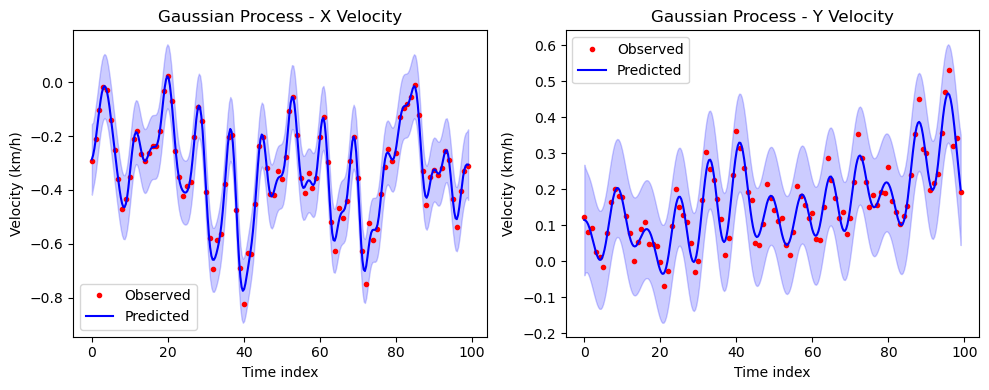

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# x-velocity
plt.subplot(1,2,1)
plt.plot(time_points, u_vector, 'r.', label='Observed')
plt.plot(time_pred, u_pred, 'b-', label='Predicted')
plt.fill_between(time_pred.flatten(), u_pred-3*u_std, u_pred+3*u_std, color='blue', alpha=0.2)
plt.title("Gaussian Process - X Velocity")
plt.xlabel("Time index")
plt.ylabel("Velocity (km/h)")
plt.legend()

# y-velocity
plt.subplot(1,2,2)
plt.plot(time_points, v_vector, 'r.', label='Observed')
plt.plot(time_pred, v_pred, 'b-', label='Predicted')
plt.fill_between(time_pred.flatten(), v_pred-3*v_std, v_pred+3*v_std, color='blue', alpha=0.2)
plt.title("Gaussian Process - Y Velocity")
plt.xlabel("Time index")
plt.ylabel("Velocity (km/h)")
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
## problem 4.b more locations


In [34]:
locations = [
    (100, 150),  # y, x
    (250, 400),
    (400, 200)
]


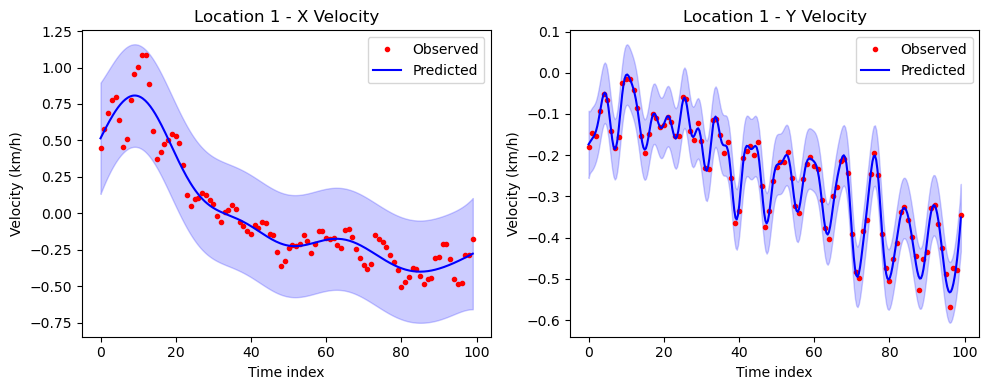

Location 1 fitted kernel for u: 0.347**2 * RBF(length_scale=12.6) + WhiteKernel(noise_level=0.0126)
Location 1 fitted kernel for v: 0.228**2 * RBF(length_scale=2.08) + WhiteKernel(noise_level=0.000385)
-----------------------------------------------------


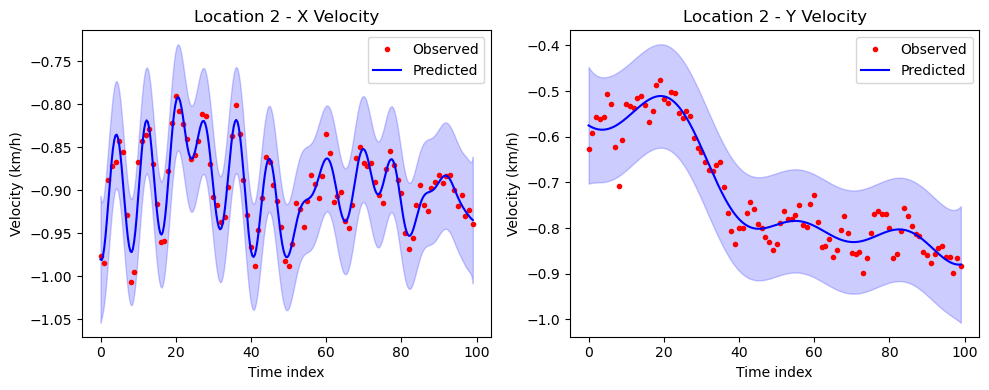

Location 2 fitted kernel for u: 0.661**2 * RBF(length_scale=4.61) + WhiteKernel(noise_level=0.000325)
Location 2 fitted kernel for v: 0.535**2 * RBF(length_scale=18.2) + WhiteKernel(noise_level=0.00132)
-----------------------------------------------------


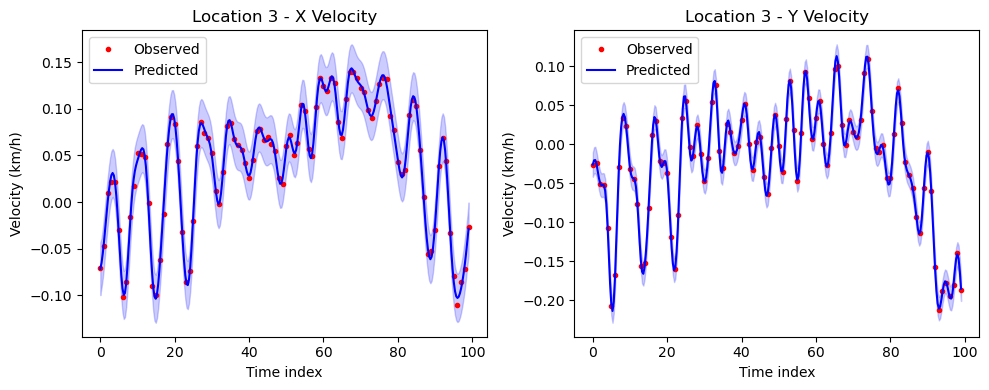

Location 3 fitted kernel for u: 0.0724**2 * RBF(length_scale=1.87) + WhiteKernel(noise_level=4.62e-05)
Location 3 fitted kernel for v: 0.0825**2 * RBF(length_scale=1.43) + WhiteKernel(noise_level=1.38e-05)
-----------------------------------------------------


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
import warnings

# Ignore convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# Loop through locations
for idx, (y_loc, x_loc) in enumerate(locations):
    # Time series data
    u_vector = U[:, y_loc, x_loc]  # x-velocity
    v_vector = V[:, y_loc, x_loc]  # y-velocity
    time_points = np.arange(100)

    # Define GP kernel
    kernel = ConstantKernel(1.0, (1e-3, 10.0)) * RBF(length_scale=10.0, length_scale_bounds=(1.0,50.0)) \
             + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5,1))

    # Fit GP for u
    gp_u = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp_u.fit(time_points.reshape(-1,1), u_vector)

    # Fit GP for v
    gp_v = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp_v.fit(time_points.reshape(-1,1), v_vector)

    # Predict at finer time points
    time_pred = np.linspace(0, 99, 300).reshape(-1,1)
    u_pred, u_std = gp_u.predict(time_pred, return_std=True)
    v_pred, v_std = gp_v.predict(time_pred, return_std=True)

    # Plot
    plt.figure(figsize=(10,4))

    # X-velocity
    plt.subplot(1,2,1)
    plt.plot(time_points, u_vector, 'r.', label='Observed')
    plt.plot(time_pred, u_pred, 'b-', label='Predicted')
    plt.fill_between(time_pred.flatten(), u_pred-3*u_std, u_pred+3*u_std, color='blue', alpha=0.2)
    plt.title(f"Location {idx+1} - X Velocity")
    plt.xlabel("Time index")
    plt.ylabel("Velocity (km/h)")
    plt.legend()

    # Y-velocity
    plt.subplot(1,2,2)
    plt.plot(time_points, v_vector, 'r.', label='Observed')
    plt.plot(time_pred, v_pred, 'b-', label='Predicted')
    plt.fill_between(time_pred.flatten(), v_pred-3*v_std, v_pred+3*v_std, color='blue', alpha=0.2)
    plt.title(f"Location {idx+1} - Y Velocity")
    plt.xlabel("Time index")
    plt.ylabel("Velocity (km/h)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print fitted kernel parameters
    print(f"Location {idx+1} fitted kernel for u: {gp_u.kernel_}")
    print(f"Location {idx+1} fitted kernel for v: {gp_v.kernel_}")
    print("-----------------------------------------------------")


In [36]:
## Step 4.c — Effect of different noise variance

In [37]:
alpha_values = [0.01, 0.5]  # Different noise levels
y_loc, x_loc = 100, 150     # You can use the first location from 4.a


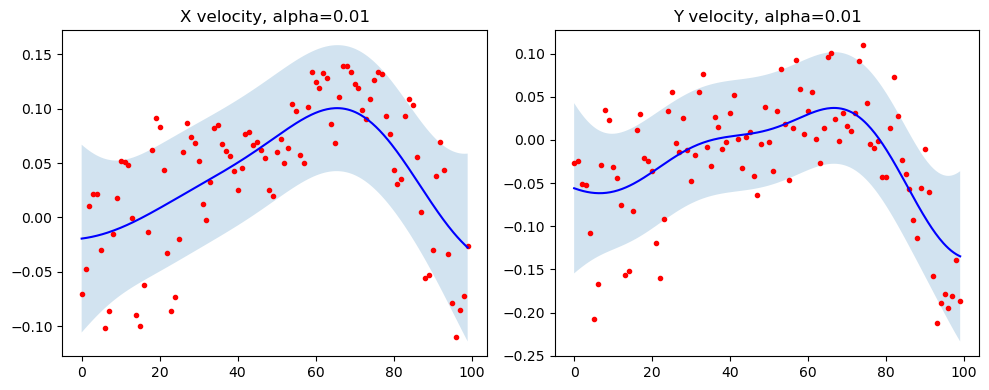

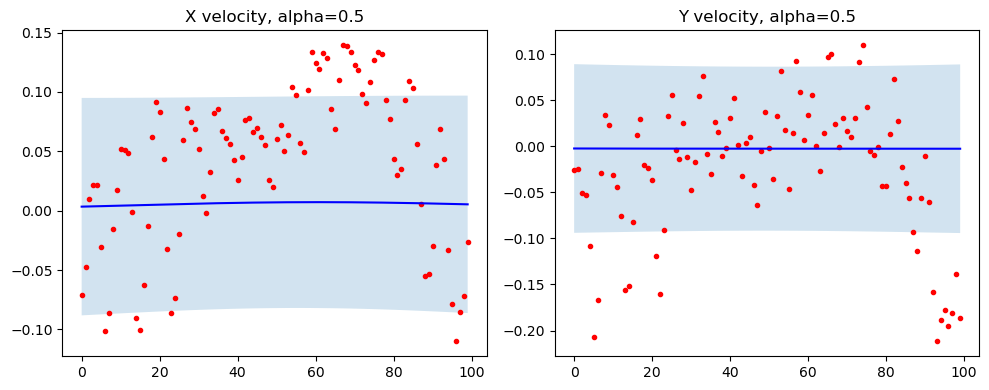

In [38]:
for alpha in alpha_values:
    gp_u = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)
    gp_u.fit(time_points.reshape(-1,1), u_vector)
    
    gp_v = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)
    gp_v.fit(time_points.reshape(-1,1), v_vector)
    
    # Predict
    u_pred, u_std = gp_u.predict(time_pred, return_std=True)
    v_pred, v_std = gp_v.predict(time_pred, return_std=True)
    
    # Plot
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.plot(time_points, u_vector, 'r.', label='Observed')
    plt.plot(time_pred, u_pred, 'b-', label='Predicted')
    plt.fill_between(time_pred.flatten(), u_pred-3*u_std, u_pred+3*u_std, alpha=0.2)
    plt.title(f"X velocity, alpha={alpha}")
    
    plt.subplot(1,2,2)
    plt.plot(time_points, v_vector, 'r.', label='Observed')
    plt.plot(time_pred, v_pred, 'b-', label='Predicted')
    plt.fill_between(time_pred.flatten(), v_pred-3*v_std, v_pred+3*v_std, alpha=0.2)
    plt.title(f"Y velocity, alpha={alpha}")
    
    plt.tight_layout()
    plt.show()

In [39]:
# Problem 5 — Estimating Unobserved Flow Data


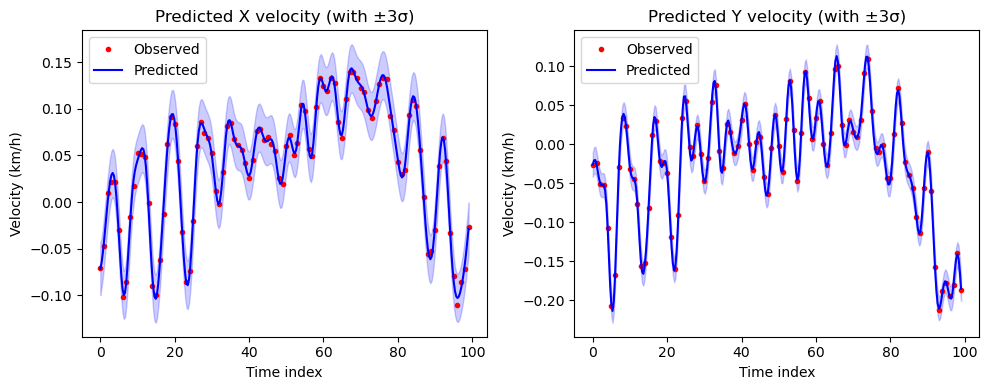

In [40]:
time_pred = np.linspace(0, 99, 300).reshape(-1,1)
gp_u = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_u.fit(time_points.reshape(-1,1), u_vector)

gp_v = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_v.fit(time_points.reshape(-1,1), v_vector)

u_pred, u_std = gp_u.predict(time_pred, return_std=True)
v_pred, v_std = gp_v.predict(time_pred, return_std=True)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(time_points, u_vector, 'r.', label='Observed')
plt.plot(time_pred, u_pred, 'b-', label='Predicted')
plt.fill_between(time_pred.flatten(), u_pred-3*u_std, u_pred+3*u_std, color='blue', alpha=0.2)
plt.title("Predicted X velocity (with ±3σ)")
plt.xlabel("Time index")
plt.ylabel("Velocity (km/h)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(time_points, v_vector, 'r.', label='Observed')
plt.plot(time_pred, v_pred, 'b-', label='Predicted')
plt.fill_between(time_pred.flatten(), v_pred-3*v_std, v_pred+3*v_std, color='blue', alpha=0.2)
plt.title("Predicted Y velocity (with ±3σ)")
plt.xlabel("Time index")
plt.ylabel("Velocity (km/h)")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Problem 6


In [ ]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

global_kernel = ConstantKernel(1.0) * RBF(length_scale=10.0) + WhiteKernel(0.01)


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

def gp_flow_at_point(time_days, flow_series):
    t_obs = np.arange(0, 300, 3).reshape(-1, 1)
    gp = GaussianProcessRegressor(kernel=global_kernel, normalize_y=True)
    gp.fit(t_obs, flow_series)
    mean, _ = gp.predict(np.array([[time_days]]), return_std=True)
    return mean[0]


In [ ]:
def km_to_index(x_km, y_km):
    ix = int(np.clip(x_km // 3, 0, U.shape[2]-1))
    iy = int(np.clip(y_km // 3, 0, U.shape[1]-1))
    return iy, ix


In [ ]:
def simulate_particle(x0, y0, days=300):
    x, y = x0, y0
    traj = [(x, y)]
    landed = False

    for t in range(days):
        iy, ix = km_to_index(x, y)

        u_series = U[:, iy, ix]
        v_series = V[:, iy, ix]

        u = gp_flow_at_point(t, u_series)
        v = gp_flow_at_point(t, v_series)

        x += u
        y += v

        traj.append((x, y))

        if u == 0 and v == 0:
            landed = True
            break

    return np.array(traj), landed
    
mean = [300, 1050]
sigma = 50  # km

particles = np.random.multivariate_normal(mean, [[sigma**2,0],[0,sigma**2]], size=200)


In [ ]:
trajectories = []
landed_points = []

for p in particles:
    traj, landed = simulate_particle(p[0], p[1])
    trajectories.append(traj)
    if landed:
        landed_points.append(traj[-1])
